In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold
from rdkit.Chem import Draw
from rdkit import DataStructs
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from scipy.spatial import distance
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.preprocessing import StandardScaler

# DrugBank data

In [2]:
df = pd.read_csv('VEGF2.csv')
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]
df.head()

,cmpd_chembl_id,canonical_smiles,value,mol
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.890,<rdkit.Chem.rdchem.Mol object at 0x000001633F2...
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.600,<rdkit.Chem.rdchem.Mol object at 0x000001633F2...
2,CHEMBL221053,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1,8.220,<rdkit.Chem.rdchem.Mol object at 0x000001633F2...
3,CHEMBL3754450,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5c...,5.470,<rdkit.Chem.rdchem.Mol object at 0x000001633F2...
4,CHEMBL383255,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3,7.105,<rdkit.Chem.rdchem.Mol object at 0x000001633F2...


In [3]:
drug = Chem.SDMolSupplier('drugbank.sdf')

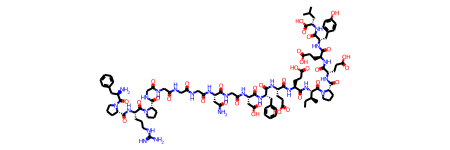

In [4]:
drug[0]

In [5]:
drug[0].GetProp("SMILES")

'CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O'

In [4]:
finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in df.mol] #do vzdálenosti 2
df['finger'] = finger

In [5]:
ids=[]
for i in range(len(drug)):
    if drug[i] is not None:
        ids.append(drug[i].GetProp('DATABASE_ID')) 

In [6]:
inchi=[]
for i in range(len(drug)):
    if drug[i] is not None:
        inchi.append(drug[i].GetProp('INCHI_IDENTIFIER')) 

In [7]:
data = {'id': ids,
        'inchi': inchi}
drug_df = pd.DataFrame(data, columns = ['id', 'inchi'])

In [8]:
drug_df['mol'] = [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']]
drug_df = drug_df.dropna()

In [9]:
drug_finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in drug_df.mol]
drug_df['finger'] = drug_finger

In [148]:
similar = []
for j in range(len(drug_df)):
    for i in range(len(df)):
        res = DataStructs.FingerprintSimilarity(df.finger[i], drug_finger[j])
        if res > 0.7:
            similar.append((df.cmpd_chembl_id[i], drug_df.id[j], res))

In [149]:
similar[:10] # vsechny 

[('CHEMBL3968843', 'DB00317', 0.796875),
 ('CHEMBL3759754', 'DB00317', 0.7361111111111112),
 ('CHEMBL434311', 'DB00317', 0.7391304347826086),
 ('CHEMBL25610', 'DB00317', 0.7101449275362319),
 ('CHEMBL3920551', 'DB00317', 0.7012987012987013),
 ('CHEMBL939', 'DB00317', 1.0),
 ('CHEMBL169797', 'DB00317', 0.7205882352941176),
 ('CHEMBL3957025', 'DB00317', 0.7671232876712328),
 ('CHEMBL24137', 'DB00317', 0.7761194029850746),
 ('CHEMBL3929448', 'DB00317', 0.7105263157894737)]

In [150]:
len(similar)

172

In [151]:
res

0.0898876404494382

In [153]:
sim = pd.DataFrame(similar)
sim.to_csv('similar.txt', index=None, sep=' ', mode='a')

# Deskriptory DrugBank vs VEGF

In [19]:
TPSA = [Descriptors.TPSA(i) for i in df.mol]
logP = [Descriptors.MolLogP(i) for i in df.mol]
HBA = [rdMolDescriptors.CalcNumHBA(i) for i in df.mol]
HBD = [rdMolDescriptors.CalcNumHBD(i) for i in df.mol]

TPSA_drug = [Descriptors.TPSA(i) for i in drug_df.mol]
logP_drug = [Descriptors.MolLogP(i) for i in drug_df.mol]
HBA_drug = [rdMolDescriptors.CalcNumHBA(i) for i in drug_df.mol]
HBD_drug = [rdMolDescriptors.CalcNumHBD(i) for i in drug_df.mol]

In [20]:
l = logP + logP_drug
t = TPSA + TPSA_drug
hba = HBA + HBA_drug
hbd = HBD + HBD_drug
s = 6715*['VEGF']+ len(logP_drug)*['drug']

In [25]:
data = {'TPSA': t,
        'logP': l,
        'HBD': hbd,
        'HBA': hba,
        'source': s}
d = pd.DataFrame(data, columns = ['TPSA', 'logP', 'HBD', 'HBA', 'source'])

<AxesSubplot:xlabel='logP', ylabel='TPSA'>

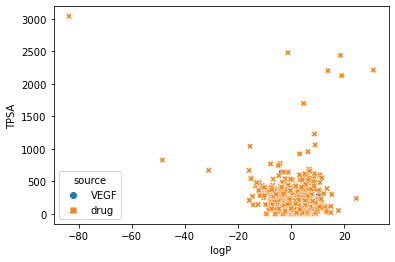

In [26]:
sns.scatterplot(data = d, x='logP', y='TPSA',  hue="source", style = 'source')

<AxesSubplot:xlabel='HBD', ylabel='HBA'>

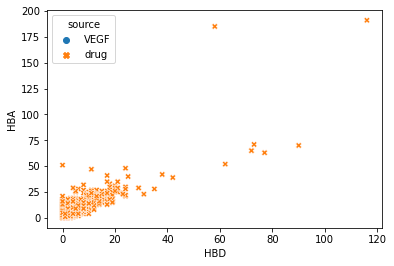

In [27]:
sns.scatterplot(data = d, x='HBD', y='HBA',  hue="source", style = 'source')

In [23]:
drug_df.loc[drug_df.id == 'DB07145']['mol']

5019    <rdkit.Chem.rdchem.Mol object at 0x000001F7F05...
Name: mol, dtype: object

In [42]:
similar_drug = set()
all_similar_drug = []

In [43]:
for i in range(len(similar)):
    similar_drug.add(similar[i][1])
    all_similar_drug.append(similar[i][1])

In [31]:
len(similar_drug)

46

In [35]:
df_hit = drug_df.loc[drug_df.id.isin(similar_drug)]

In [38]:
df_hit.head()

,id,inchi,mol,finger
207,DB00317,InChI=1S/C22H24ClFN4O3/c1-29-20-13-19-16(12-21...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
504,DB00619,InChI=1S/C29H31N7O/c1-21-5-10-25(18-27(21)34-2...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1129,DB01254,InChI=1S/C22H26ClN7O2S/c1-14-4-3-5-16(23)20(14...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1574,DB01809,InChI=1S/C16H19N5/c1-10-5-7-11(8-6-10)13-12-14...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1615,DB01852,InChI=1S/C15H10O6/c16-8-3-1-7(2-4-8)15-14(20)1...,<rdkit.Chem.rdchem.Mol object at 0x000001F7ED5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


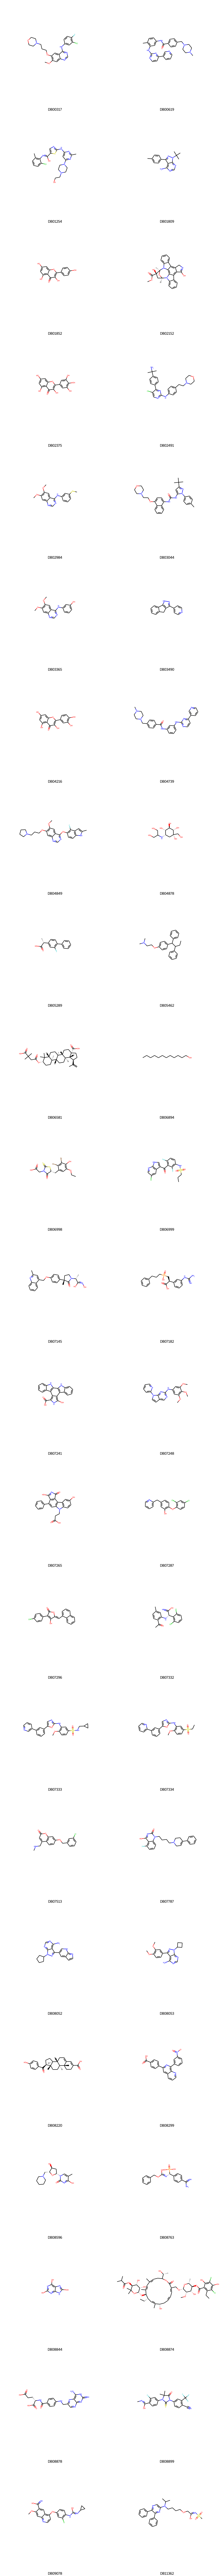

In [39]:
# DrugBank struktury ktere jsou podobne nekterym strukturam v VEGF datasetu
# ktery molekuly z drugbank jsou podobne tem našem
index = df_hit.index
Draw.MolsToGridImage([drug_df.mol[index[i]] for i in range(0,len(df_hit))], molsPerRow=2, subImgSize=(500,500),
                     legends=["{}".format(sim) for sim in df_hit.id])

In [45]:
len(all_similar_drug)

172

In [46]:
data = {'id': all_similar_drug}
df_similar = pd.DataFrame(data, columns = ['id'])

In [47]:
df_similar['id'].value_counts()

DB07333    20
DB04878    15
DB08763    14
DB05289    14
DB00317    10
DB07334    10
DB08053     7
DB07145     7
DB03365     7
DB08052     6
DB07248     6
DB11362     5
DB02491     4
DB02984     4
DB08596     3
DB02152     3
DB07296     3
DB08299     3
DB06581     3
DB07332     2
DB01254     1
DB08844     1
DB08874     1
DB08878     1
DB08220     1
DB08899     1
DB01809     1
DB01852     1
DB09078     1
DB07787     1
DB07513     1
DB04216     1
DB02375     1
DB04739     1
DB07287     1
DB07265     1
DB07241     1
DB00619     1
DB06999     1
DB06998     1
DB06894     1
DB05462     1
DB03044     1
DB03490     1
DB04849     1
DB07182     1
Name: id, dtype: int64

In [49]:
drug_df.loc[drug_df.id == 'DB07333']['mol']

5205    <rdkit.Chem.rdchem.Mol object at 0x000001F7F05...
Name: mol, dtype: object

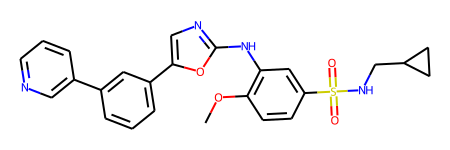

In [50]:
drug_df.mol[5205]

## MQNs

In [61]:
MQNs = np.array([rdMolDescriptors.MQNs_(i) for i in df.mol] + [rdMolDescriptors.MQNs_(i) for i in drug_df.mol])
df_MQNs = pd.DataFrame(MQNs)

In [62]:
df_MQNs.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,28,0,0,0,0,0,0,0,2,3,...,0,0,3,3,0,0,0,0,10,5
1,24,0,0,0,0,0,0,1,3,2,...,0,0,1,4,0,0,0,0,4,2
2,22,0,0,0,0,0,0,3,2,1,...,0,0,1,3,0,0,0,0,2,1
3,27,0,0,0,0,0,0,0,4,2,...,0,0,0,5,0,0,0,0,2,1
4,19,3,0,0,0,0,0,2,5,1,...,0,0,2,2,0,0,0,0,0,0


In [65]:
df_MQNs['source'] = d.source

<AxesSubplot:xlabel='0', ylabel='1'>

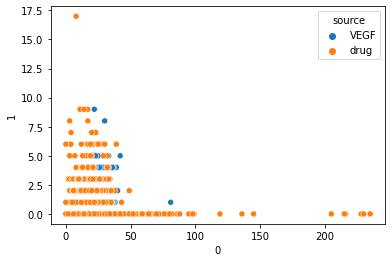

In [115]:
sns.scatterplot(data = df_MQNs, x=0, y=1, hue='source')

In [154]:
data = df_MQNs.iloc[: , :5]
data['source'] = df_MQNs.source

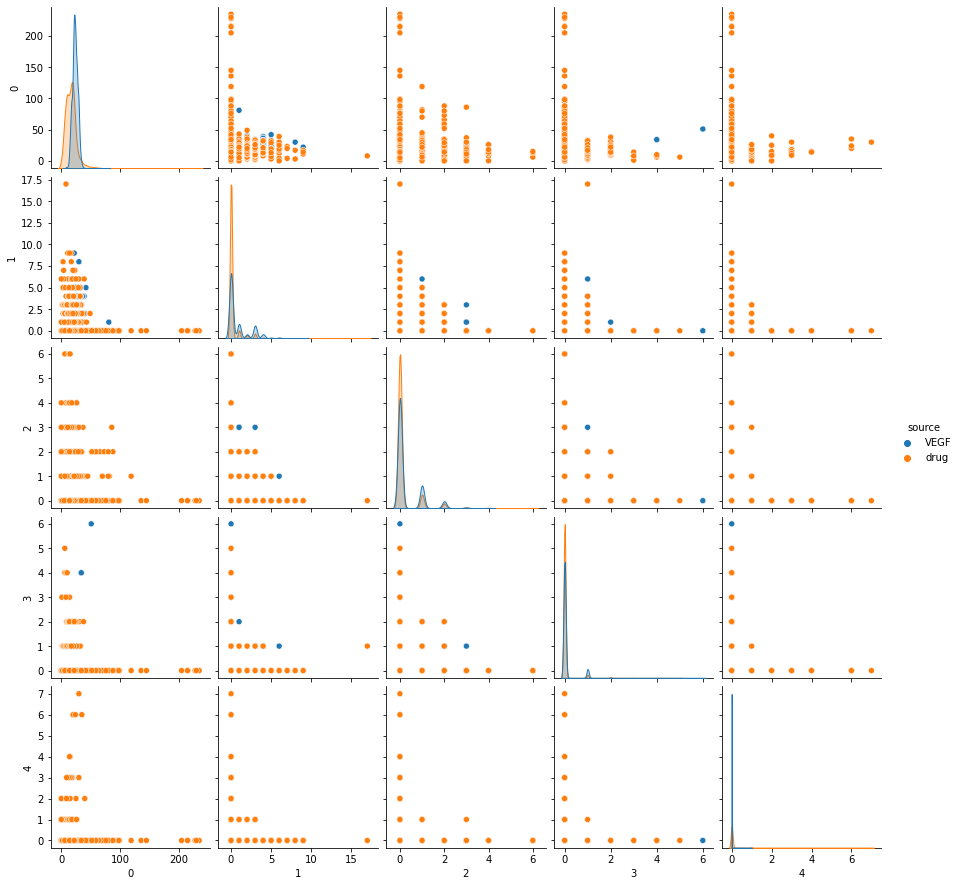

In [129]:
sns.pairplot(data, hue='source')

# PCA

shape:  (13827, 19)


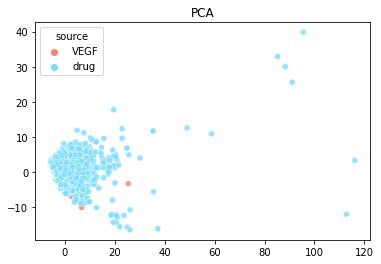

In [80]:
pca = PCA(0.9)
MQNs_2 = StandardScaler().fit_transform(MQNs)
PCA_com = pca.fit_transform(MQNs_2)
colors =['salmon','#7BDDFF'] # #FF7BD7
plot = sns.scatterplot(x=PCA_com[:,0], y=PCA_com[:,1], hue=df_MQNs['source'], alpha=0.8, palette=colors).set_title('PCA')
print('shape: ', PCA_com.shape)

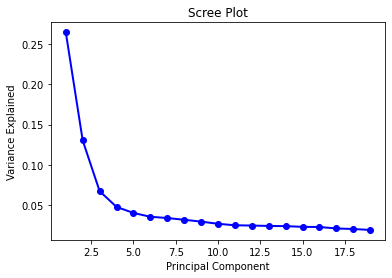

In [83]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# MDS

In [10]:
fingers = list(drug_df.finger) + list(df.finger)

In [13]:
sparse = distance.pdist(fingers, metric="jaccard")
distance = distance.squareform(sparse)
clf = MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")

In [14]:
distance

array([[0.        , 0.57051282, 0.57857143, ..., 0.85507246, 0.89403974,
        0.91970803],
       [0.57051282, 0.        , 0.63225806, ..., 0.84459459, 0.86792453,
        0.91216216],
       [0.57857143, 0.63225806, 0.        , ..., 0.86046512, 0.89361702,
        0.95419847],
       ...,
       [0.85507246, 0.84459459, 0.86046512, ..., 0.        , 0.88349515,
        0.93333333],
       [0.89403974, 0.86792453, 0.89361702, ..., 0.88349515, 0.        ,
        0.77906977],
       [0.91970803, 0.91216216, 0.95419847, ..., 0.93333333, 0.77906977,
        0.        ]])

In [ ]:
fps_mds = clf.fit_transform(distance)
plot = sns.scatterplot(x=fps_mds[:,0], y=fps_mds[:,1], hue=d['source']).set_title('MDS')
print('shape: ', fps_mds.shape)

In [11]:
sparse_mat = distance.pdist(finger, metric="jaccard")
dist_mat = distance.squareform(sparse_mat)
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
fps_mds = clf.fit_transform(dist_mat)

shape:  (6715, 2)


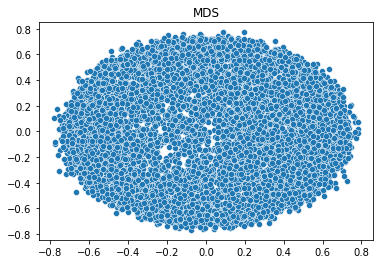

In [12]:
plot = sns.scatterplot(x=fps_mds[:,0], y=fps_mds[:,1]).set_title('MDS')
print('shape: ', fps_mds.shape)

# t-SNE

C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


shape:  (13827, 2)


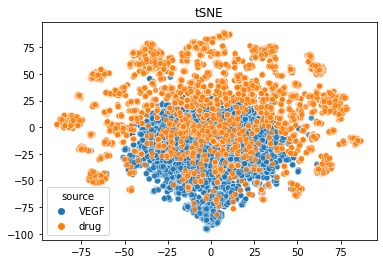

In [137]:
fps_tsne = TSNE(n_components=2, perplexity=50, init='random').fit_transform(fingers)
plot = sns.scatterplot(x=fps_tsne[:,0], y=fps_tsne[:,1], hue=d['source'], alpha=0.8).set_title('tSNE')
print('shape: ', fps_tsne.shape)